# Basic of probability and statistics
In this notebook we will take our first steps in exploring the basics of probability and statistics.
Specifically we will:

* Use scipy and numpy to generate Gaussian-distributed random numbers.
* Demonstrate that MC-based histograms based on these random numbers can approximate the underlying pdfs.
* Show that for vectors of $M$ independent Gaussian-distributed random numbers, the $\chi^{2}$ **test statistic** obeys a $\chi^{2}$ **distribution**.
* Use this distribution to quantify how well an experimental result supports a hypothesis

**First we import the necessary python packages**

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import numpy as np

**Generating random numbers that obey a Gaussian distribution**

* initalisation:
    * the mean (mu) and standard deviation (sigma) of the underlying Gaussian distribution 
    * the number of random numbers we want to generate
    * the number of bins in our histogram
    
* generation:
   * np.random module is callend and events are filled into a pandas dataframe
   * events are then binned in a np.histogram
   * density=True sets the histogram integral = 1, allowing direct comparison to the underlying pdf

* we plot the histogram with the pdf overlaid
* **change nEvents and nBins and re-run this cell to see how well the MC histogram can approximate the pdf**

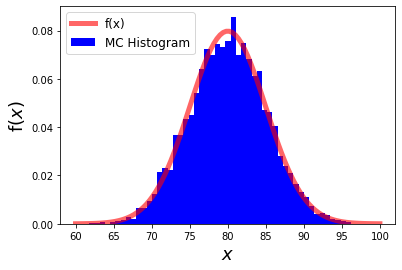

In [3]:
mu = 80.0
sigma = 5.0
nEvents = 5000
nBins = 50

df = pd.DataFrame(np.random.normal(loc=mu, scale=sigma, size=nEvents), columns=['events'])
dataCounts, dataBins = np.histogram(df, bins=nBins, density=True)
binCentres = (dataBins[:-1] + dataBins[1:]) / 2
width = np.diff(dataBins)

plt.figure()
plt.bar(binCentres, dataCounts, align='center', width=width, label='MC Histogram', color='b')

ax = plt.gca()
labely = ax.set_xlabel("$x$", fontsize = 18)
labely = ax.set_ylabel("f($x$)", fontsize = 18)

x = np.linspace(60.0, 100.0, 100)
ax.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=5, alpha=0.6, label='f(x)')

legend = ax.legend(loc='upper left', fontsize='large')
plt.show()
plt.close()

# Using the $\chi^{2}$ test statistic to perform a hypothesis test

* Imagine we perform a single experiment that takes a reading of x nEvents times
    * e.g., x could be $m_{jj}$
    
* We would like quantify how well the data fit a hypothesis
    * **Hypothesis**: data are Gaussian-distributed with mean $\mu=80$ and standard deviation $\sigma=5.0$

* The $\chi^{2}$ *test statistic* quantifies how well the data supports a hypothesis
    
* The $\chi^{2}$ test statistic for a histogram of gaussian-distributed observations $x_i$ and corresponding model predictions $p_{i}$ is defined:
    *  $\chi^{2} = \sum\limits_{i=1}^{i = nBins} \frac{(x_{i} - p_{i})^{2}}{p_{i}}$

*  $\chi^{2}$ is calculated by the function below

In [59]:
def calcChiSq(obs, preds):
    chiSq = 0.0
    for bin in range(0, len(obs)):
        diff = preds[bin] - obs[bin]
        var = np.abs(preds[bin])
        chiSq += (diff**2)/(var)
    return chiSq

* The $\chi^{2}$ value is large if the data doesn't fit the hypothesis well and vice versa
    * But how large is 'large'? 
    * Can we ever conclude that the data does/does not satisfy the hypothesis?
      * No, but we can make a quatitative statement on **how likely our data is if the hyothesis is true**
    
* How is the $\chi^{2}$ test statistic distributed if the hypothesis is true? 

* *Counter-factual* reasoning:
    * imagine a infinte set of imaginary experiments (*identical* to ours) that could have been perform 
    * simulate a subset 'toy' experiments by generating random results from our model
    * for each toy, calculate the $\chi^{2}$ value

* To simulate a toy experiment, we need a function that:
    * takes a list of numbers $p_i$ as input
    * returns a list of random numbers $r_i$ distibuted with means $p_i$ and standard deviations $\sqrt{p_i}$

In [72]:
def genRandHist(pdfPreds):
    randHist = np.empty(nBins)
    for bin in range(0, len(pdfPreds)):
        mu = pdfPreds[bin]
        sigma = np.sqrt(mu)
        randBin = np.random.normal(loc=mu, scale=sigma)
        randHist[bin] = randBin
    return randHist

* now we run our toy experiments and calculate the $\chi^{2}$ value for each one
* evaluate the pdf at the bin centres for the $\chi^{2}$ calculation

In [73]:
nToys = 10000
chiSqAr = np.empty(nToys)

pdfPreds = stats.norm.pdf(binCentres, mu, sigma)

for toy in range(0, nToys):
    toyHist = genRandHist(pdfPreds)
    chiSq = calcChiSq(toyHist, pdfPreds)
    chiSqAr[toy] = chiSq

* we plot the distribution of $\chi^{2}$ values
* theory says this distribution should follow a $\chi^{2}$ function with ndof = nBins

<Figure size 432x288 with 0 Axes>

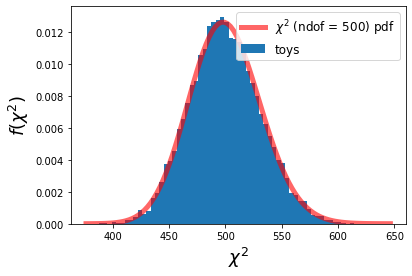

In [74]:
plt.figure()
fig, ax1 = plt.subplots()
h = plt.hist(chiSqAr, bins='auto', density=True, label='toys')
df = nBins
x = np.linspace(stats.chi2.ppf(0.00001, df), stats.chi2.ppf(0.99999, df), 100)
label = '$\chi^{2}$ (ndof = ' + str(nBins) + ') pdf'
ax1.plot(x, stats.chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=label)
labely = ax1.set_xlabel("$\chi^{2}$", fontsize = 18)
labely = ax1.set_ylabel("$f(\chi^{2})$", fontsize = 18)
legend = ax1.legend(loc='upper right', fontsize='large')
plt.show()

* now we can make a **quantitative** statement about how well our **real** experiment fits our hypothesis
    * calculate $\chi_{real}^{2}$ for our **real** experiment
    
    * p-value = $\int_{\chi_{real}^{2}}^{+\infty} f(\chi^{2})d\chi^{2} = 1 - F(\chi^{2})$
    
    * p-value = "probability that an experiment would give a result more extreme than this **if the hypothesis is true**"

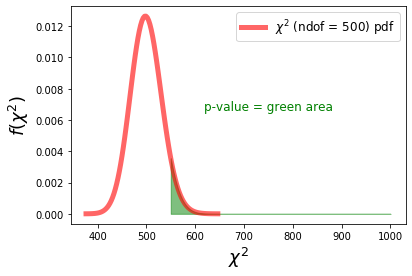

In [100]:
fig, ax = plt.subplots()

ax.plot(x, stats.chi2.pdf(x, df), 'r-', lw=5, alpha=0.6, label=label)
ax.set_xlabel("$\chi^{2}$", fontsize = 18)
ax.set_ylabel("$f(\chi^{2})$", fontsize = 18)
legend = ax.legend(loc='upper right', fontsize='large')

realChi2 = nBins*1.1
px=np.arange(realChi2,1000,0.001)
ax.fill_between(px,stats.chi2.pdf(px, df),alpha=0.5, color='g')

left, right = plt.xlim()
bottom, top = plt.ylim()
ax.text(right*0.6, top*0.5,"p-value = green area", color='g', fontsize=12)
plt.show()


* we can now relate the $\chi_{real}^{2}$ value from our experiment to a p-value
* plot relationship between $\chi^{2}$ and p-value for **this example**

<Figure size 432x288 with 0 Axes>

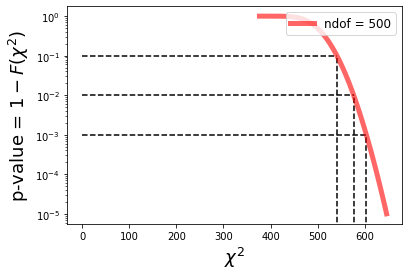

In [102]:
x = np.linspace(stats.chi2.ppf(0.00001, df), stats.chi2.ppf(0.99999, df), 100)
pval = (1.0 - stats.chi2.cdf(x, df))

plt.figure()
fig, ax1 = plt.subplots()
plt.yscale("log")

labely = ax1.set_xlabel("$\chi^{2}$", fontsize = 18)
labely = ax1.set_ylabel("p-value = $1 - F(\chi^{2})$", fontsize = 18)

label= "ndof = " + str(nBins)
ax1.plot(x, pval, 'r-', lw=5, alpha=0.6, label=label)
legend = ax1.legend(loc='upper right', fontsize='large')

yCV = [0.1, 0.01, 0.001]

for p in yCV:
    xCV = stats.chi2.ppf((1.0 - p), df)
    plt.hlines(p, 0.0, xCV,  linestyle="dashed")
    plt.vlines(xCV, 0.0, p,  linestyle="dashed")
    
plt.show()